# Churn Prediction Model using external dataset from IBM
## Date : 2019-02-22

This notebook is a tutorial that takes you through a churn prediction model using the customer churn data from IBM called WA_Fn UseC_ Telco Customer Churn.csv . You can download this dataset by going to : https://www.ibm.com/communities/analytics/watson-analytics-blog/guide-to-sample-datasets/

In [1]:
#Install the necessary libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
%matplotlib inline



#import warnings to ignore these warnings of fonts
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore", category=PendingDeprecationWarning)

## Download Data

Once we have imported the libraries we need for this notebook, we will download the data, and have a look at the structure of the data.

In [174]:
telco_df = pd.read_csv("data/WA_Fn-UseC_-Telco-Customer-Churn.csv")


In [118]:
telco_df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [119]:
telco_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), obj

We see that this dataset has 7043 entries, 21 columns where 3 columns are numerical (int64/float64) and 18 columns are objects. 

## Exploring and Cleaning the dataset

We want to see the different unique combination to understand which columns can be converted to binary

In [120]:
for item in telco_df.columns:
    print(item)
    print (telco_df[item].unique())

customerID
['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
gender
['Female' 'Male']
SeniorCitizen
[0 1]
Partner
['Yes' 'No']
Dependents
['No' 'Yes']
tenure
[ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
PhoneService
['No' 'Yes']
MultipleLines
['No phone service' 'No' 'Yes']
InternetService
['DSL' 'Fiber optic' 'No']
OnlineSecurity
['No' 'Yes' 'No internet service']
OnlineBackup
['Yes' 'No' 'No internet service']
DeviceProtection
['No' 'Yes' 'No internet service']
TechSupport
['No' 'Yes' 'No internet service']
StreamingTV
['No' 'Yes' 'No internet service']
StreamingMovies
['No' 'Yes' 'No internet service']
Contract
['Month-to-month' 'One year' 'Two year']
PaperlessBilling
['Yes' 'No']
PaymentMethod
['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (a

So, I want to convert the Yes No into a binary 1 0 for the columns I want to use, so we start with the features that only have 'Yes' and 'No

In [121]:
#selecting the columns to convert
columns_to_convert = ['Partner', 
                      'Dependents', 
                      'PhoneService', 
                      'PaperlessBilling', 
                      'Churn']

for item in columns_to_convert:
    telco_df[item].replace(to_replace='Yes', value=1, inplace=True)
    telco_df[item].replace(to_replace='No',  value=0, inplace=True)
telco_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,1,0,1,0,No phone service,DSL,No,...,No,No,No,No,Month-to-month,1,Electronic check,29.85,29.85,0
1,5575-GNVDE,Male,0,0,0,34,1,No,DSL,Yes,...,Yes,No,No,No,One year,0,Mailed check,56.95,1889.5,0
2,3668-QPYBK,Male,0,0,0,2,1,No,DSL,Yes,...,No,No,No,No,Month-to-month,1,Mailed check,53.85,108.15,1
3,7795-CFOCW,Male,0,0,0,45,0,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,0,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,Female,0,0,0,2,1,No,Fiber optic,No,...,No,No,No,No,Month-to-month,1,Electronic check,70.70,151.65,1


Now, I want to treat No internet service/No phone service as No for columns who have Yes, No and No internet service/No phone service

In [123]:
#selecting additional columns to convert, to handle the No internet service
columns_to_convert = ['DeviceProtection', 
                      'OnlineSecurity', 
                      'OnlineBackup', 
                      'TechSupport', 
                      'StreamingMovies',
                     'StreamingTV',
                     'MultipleLines']

for item in columns_to_convert:
    telco_df[item].replace(to_replace='Yes', value=1, inplace=True)
    telco_df[item].replace(to_replace='No',  value=0, inplace=True)
    telco_df[item].replace(to_replace='No internet service',value=0,inplace=True)
    telco_df[item].replace(to_replace='No phone service', value=0, inplace=True)

telco_df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,1,0,1,0,0,DSL,0,...,0,0,0,0,Month-to-month,1,Electronic check,29.85,29.85,0
1,5575-GNVDE,Male,0,0,0,34,1,0,DSL,1,...,1,0,0,0,One year,0,Mailed check,56.95,1889.5,0
2,3668-QPYBK,Male,0,0,0,2,1,0,DSL,1,...,0,0,0,0,Month-to-month,1,Mailed check,53.85,108.15,1
3,7795-CFOCW,Male,0,0,0,45,0,0,DSL,1,...,1,1,0,0,One year,0,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,Female,0,0,0,2,1,0,Fiber optic,0,...,0,0,0,0,Month-to-month,1,Electronic check,70.70,151.65,1


Now, let us look at the datatypes of our converted columns, we see that these have been converted to int64.

In [124]:
telco_df.dtypes


customerID           object
gender               object
SeniorCitizen         int64
Partner               int64
Dependents            int64
tenure                int64
PhoneService          int64
MultipleLines         int64
InternetService      object
OnlineSecurity        int64
OnlineBackup          int64
DeviceProtection      int64
TechSupport           int64
StreamingTV           int64
StreamingMovies       int64
Contract             object
PaperlessBilling      int64
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                 int64
dtype: object

However, Why is TotalCharges still an object, let us force it to numeric and check if there are any nulls and replace these with 0

In [125]:
#We see that TotalCharges is still object, so we want to fix that so it is regarded as numeric
telco_df['TotalCharges'] = telco_df['TotalCharges'].replace(r'\s+', np.nan, regex=True)
telco_df['TotalCharges'] = pd.to_numeric(telco_df['TotalCharges'])

In [126]:
#Now we check for Null
telco_df.isnull().sum(axis = 0)

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [127]:
#Now we fill the nulls
telco_df = telco_df.fillna(value=0)

# Initial Analysis
We create our churned variable by balancing the labels so that we have the same numbers of churned and not churned variables

In [128]:
#We balance the labels so that we have the same numbers of churned and not churned
churned = len(telco_df[telco_df['Churn'] == 1])
print("Number of churned", churned)

churners = (telco_df[telco_df['Churn'] == 1])

not_churned = telco_df[telco_df['Churn'] == 0].sample(n=churned)
print("Number of not churned", len(not_churned))
telco_df2 = churners.append(not_churned)

Number of churned 1869
Number of not churned 1869


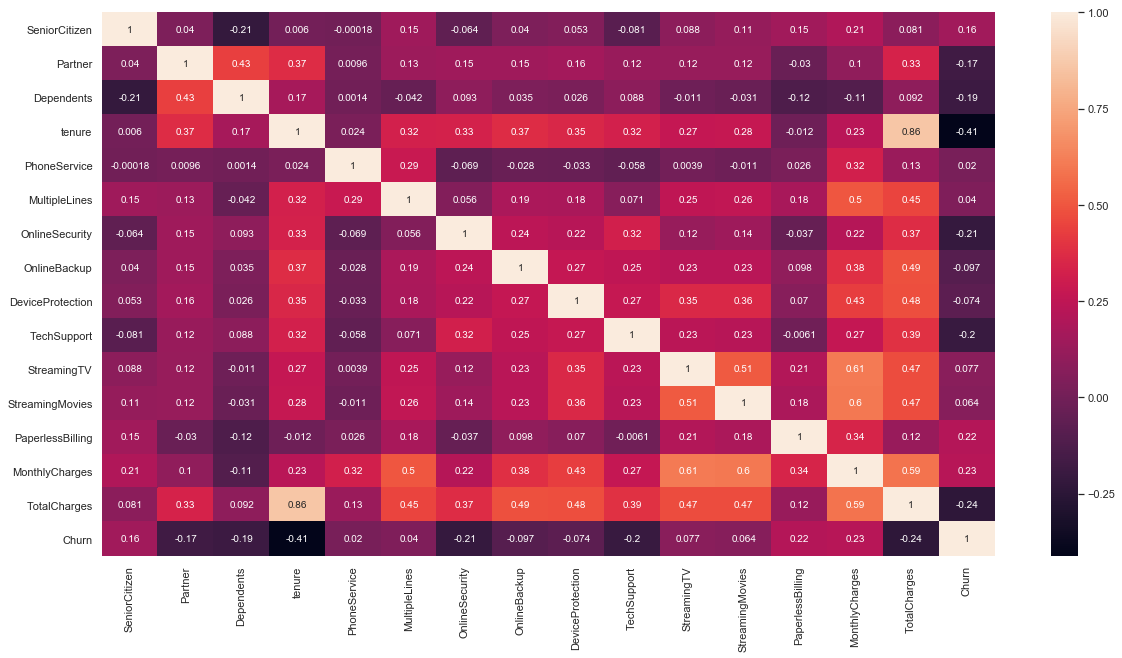

In [129]:
def show_correlations(dataframe, show_chart = True):
    fig = plt.figure(figsize = (20,10))
    corr = dataframe.corr()
    if show_chart == True:
        sns.heatmap(corr, 
                    xticklabels=corr.columns.values,
                    yticklabels=corr.columns.values,
                    annot=True)
    return corr

correlation_df = show_correlations(telco_df2,show_chart=True)

We see strong correlations between  tenure,MonthlyCharges and TotalCharges

In [130]:
#To build the classifier, we will remove the customerId,
try:
    customer_id = telco_df2['customerID'] # Store this as customer_id variable
    del telco_df2['customerID'] # Don't need it
except:
    print("already removed customerID")

In [131]:
telco_df2.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
2,Male,0,0,0,2,1,0,DSL,1,1,0,0,0,0,Month-to-month,1,Mailed check,53.85,108.15,1
4,Female,0,0,0,2,1,0,Fiber optic,0,0,0,0,0,0,Month-to-month,1,Electronic check,70.70,151.65,1
5,Female,0,0,0,8,1,1,Fiber optic,0,0,1,0,1,1,Month-to-month,1,Electronic check,99.65,820.50,1
8,Female,0,1,0,28,1,1,Fiber optic,0,0,1,1,1,1,Month-to-month,1,Electronic check,104.80,3046.05,1
13,Male,0,0,0,49,1,1,Fiber optic,0,1,1,0,1,1,Month-to-month,1,Bank transfer (automatic),103.70,5036.30,1


We will need to use one-hot encoding to fill the other categorical data into binary formats

In [147]:
#Use one-hot encoding to convert all the other categorical data to binary (0 or 1)

ml_dummies = pd.get_dummies(telco_df2)
ml_dummies.fillna(value=0, inplace=True)
ml_dummies.head()

,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,...,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
2,0,0,0,2,1,0,1,1,0,0,...,1,0,0,1,0,0,0,0,0,1
4,0,0,0,2,1,0,0,0,0,0,...,0,1,0,1,0,0,0,0,1,0
5,0,0,0,8,1,1,0,0,1,0,...,0,1,0,1,0,0,0,0,1,0
8,0,1,0,28,1,1,0,0,1,1,...,0,1,0,1,0,0,0,0,1,0
13,0,0,0,49,1,1,0,1,1,0,...,0,1,0,1,0,0,1,0,0,0


Let us look at a correlation matrix against Churn

In [148]:
# Show the correlations against Churn
show_correlations(ml_dummies, show_chart=False)["Churn"].sort_values(ascending=False)

Churn                                      1.000000
Contract_Month-to-month                    0.480808
InternetService_Fiber optic                0.347004
PaymentMethod_Electronic check             0.329510
MonthlyCharges                             0.225754
PaperlessBilling                           0.216433
SeniorCitizen                              0.155863
StreamingTV                                0.076513
StreamingMovies                            0.063728
MultipleLines                              0.040475
gender_Female                              0.024082
PhoneService                               0.019901
gender_Male                               -0.024082
DeviceProtection                          -0.074171
OnlineBackup                              -0.096525
PaymentMethod_Mailed check                -0.114018
PaymentMethod_Bank transfer (automatic)   -0.129863
InternetService_DSL                       -0.154047
PaymentMethod_Credit card (automatic)     -0.165405
Partner     

<Figure size 1440x720 with 0 Axes>

In [165]:
#We will remove the label Churn before training the model
try:
    label = ml_dummies['Churn'] 
    del ml_dummies['Churn']
except:
    print("label already removed.")

label already removed.


# Using KNeighbour
Let us Create a training and a test set, and use the KNeighbors Classifier as our model

KNeighborsClassifier
0.711 
 - - - - -  

DecisionTreeClassifier
0.744 
 - - - - -  



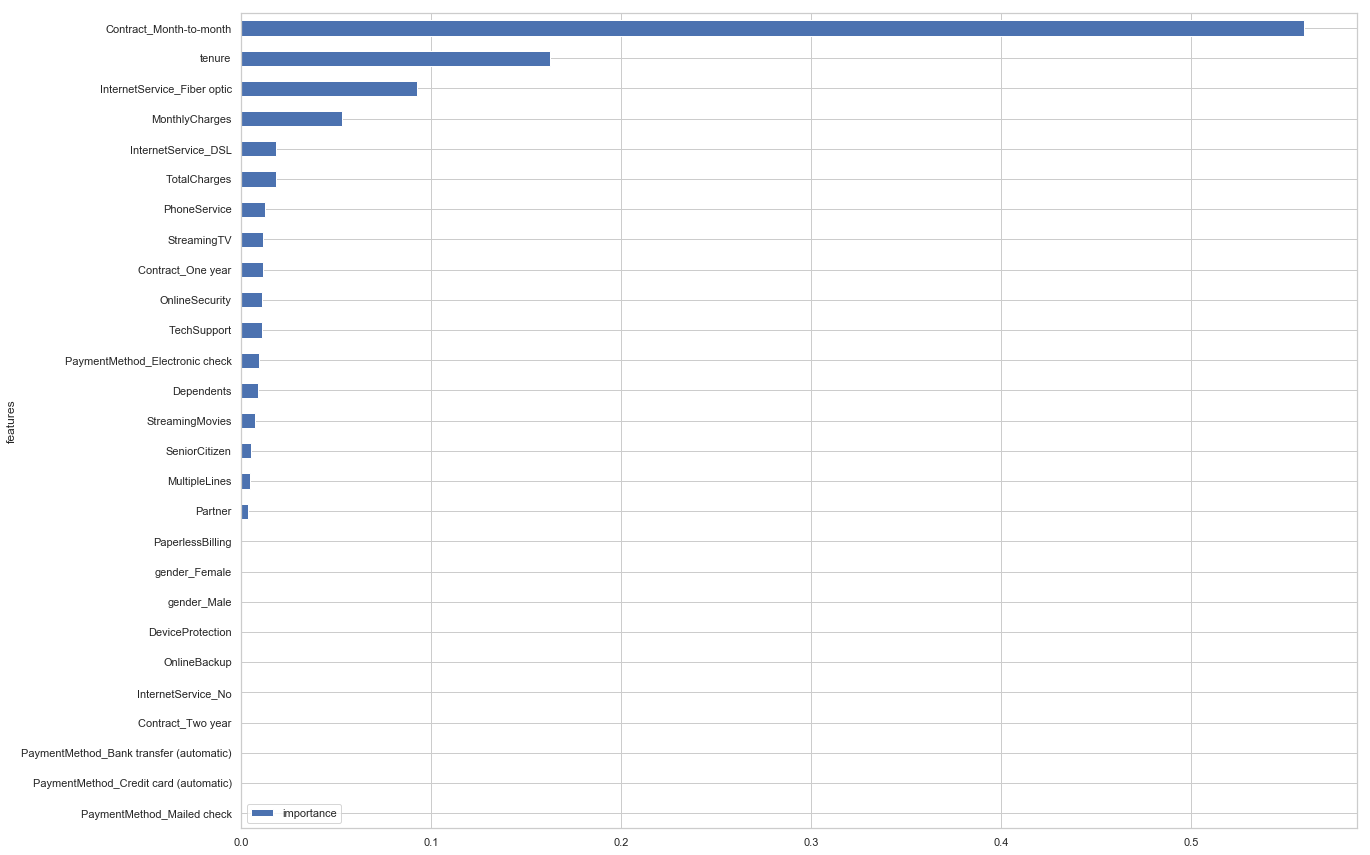

In [166]:
#Now we create our train_test set
from sklearn.model_selection import train_test_split
feature_train, feature_test, label_train, label_test = train_test_split(ml_dummies, label, test_size=0.3)

# Here we sat our Classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

classifiers = [
    KNeighborsClassifier(5),    
    DecisionTreeClassifier(max_depth=5)
]
    

# iterate over classifiers
for item in classifiers:
    classifier_name = ((str(item)[:(str(item).find("("))]))
    print (classifier_name)
    
    # Create classifier, train it and test it.
    clf = item
    clf.fit(feature_train, label_train)
    pred = clf.predict(feature_test)
    score = clf.score(feature_test, label_test)
    print (round(score,3),"\n", "- - - - - ", "\n")
    
feature_df = pd.DataFrame()
feature_df['features'] = ml_dummies.columns
feature_df['importance'] = clf.feature_importances_
feature_df.sort_values(by='importance', ascending=False)    
feature_df.set_index(keys='features').sort_values(by='importance', ascending=True).plot(kind='barh', figsize=(20, 15))

Confusion matrix, without normalization
[[422 153]
 [134 413]]
Normalized confusion matrix
[[0.73 0.27]
 [0.24 0.76]]


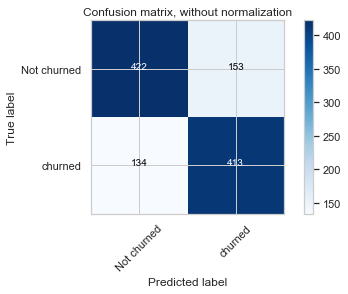

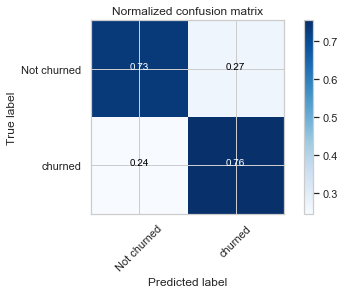

              precision    recall  f1-score   support

 Not churned       0.76      0.73      0.75       575
     churned       0.73      0.76      0.74       547

   micro avg       0.74      0.74      0.74      1122
   macro avg       0.74      0.74      0.74      1122
weighted avg       0.74      0.74      0.74      1122



In [167]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else: 
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(label_test, pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
class_names = ['Not churned','churned']

plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()


from sklearn.metrics import classification_report
eval_metrics = classification_report(label_test, pred, target_names=class_names)
print(eval_metrics)

In [ ]:
# Probability Analysis

In [168]:
from sklearn.model_selection import GridSearchCV

max_depth_range = range(2,20,2)
leaf_range = range(1,10,2)
n_estimators_range = range(10,200,10)
max_features_range = range(1,len(ml_dummies.columns),5)


param_grid = dict(max_depth = max_depth_range,
                 min_samples_leaf = leaf_range,
                 n_estimators = n_estimators_range,
                 max_features = max_features_range
                )



In [169]:
# Preprocessing original dataframe
def preprocess_df(dataframe):
    x = dataframe.copy()
    try:
        customer_id = x['customerID']
        del x['customerID'] # Don't need in ML DF
    except:
        print("already removed customerID")
    
    ml_dummies = pd.get_dummies(x)
    ml_dummies.fillna(value=0, inplace=True)

    

    try:
        label = ml_dummies['Churn']
        del ml_dummies['Churn']
    except:
        print("label already removed.")
    return ml_dummies, customer_id, label

original_df = preprocess_df(telco_df)

In [170]:
output_df = original_df[0].copy()
output_df['prediction'] = clf.predict_proba(output_df)[:,1]
output_df['churn'] = original_df[2]
output_df['customerID'] = original_df[1]

In [171]:
print('Mean predict probability of churn:',round(output_df[output_df['churn'] == 1]['prediction'].mean(),2))
print('Mean predict probability of NOT-churn:',round(output_df[output_df['churn'] == 0]['prediction'].mean(),2))

Mean predict probability of churn: 0.69
Mean predict probability of NOT-churn: 0.32


Let us show the prediction of the customers who has not churned but are likely to churn. The results are shown below based on CustomerId


In [172]:
activate = output_df[output_df['churn'] == 0]
activate[['customerID','churn','prediction']]

,customerID,churn,prediction
0,7590-VHVEG,0,0.736559
1,5575-GNVDE,0,0.119617
3,7795-CFOCW,0,0.119617
6,1452-KIOVK,0,0.779221
7,6713-OKOMC,0,0.412698
9,6388-TABGU,0,0.119617
10,9763-GRSKD,0,0.393939
11,7469-LKBCI,0,0.049451
12,8091-TTVAX,0,0.346154
14,5129-JLPIS,0,0.791667
